In [1]:
import numpy as np
import argparse
import cv2
from imutils.video import VideoStream
from imutils.video import FPS
import time
import imutils
from scipy.spatial import distance
from typing import NamedTuple
import collections
from matplotlib import pyplot as plt
import os
from mpl_toolkits import mplot3d
import math
%matplotlib inline
from IPython import display

In [2]:
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [3]:
net = cv2.dnn.readNetFromCaffe('SingleShotDetector/MobileNetSSD_deploy.prototxt.txt', 'SingleShotDetector/MobileNetSSD_deploy.caffemodel')

In [4]:
class Object(NamedTuple):
    name: str
    centroidx: float
    centroidy: float
    startX: float
    startY: float
    endX: float
    endY: float
    dissapeared: int
        
    def setDissapeared(self, disp):
        dissapeared = disp

In [5]:
# print("[INFO] starting video stream...")
# vs = VideoStream(src=0).start()
# time.sleep(2.0)
# fps = FPS().start()

In [6]:
def getBoundingBoxes(detections):

    new_objects = []

    # loop over the detections
    for i in np.arange(0, detections.shape[2]):

        # extract the confidence (i.e., probability) associated with the
        # prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > 0.8:
            # extract the index of the class label from the `detections`,
            # then compute the (x, y)-coordinates of the bounding box for
            # the object
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            
            x_centre = (box.astype("int")[0] + box.astype("int")[2]/2).astype("int")
            y_centre = (box.astype("int")[1] + box.astype("int")[3]/2).astype("int")   

            if y_centre >= 300:
                y_centre = 299
            if x_centre >= 400:
                x_centre = 399
            new_objects.append(Object(CLASSES[idx], x_centre, y_centre, startX, startY, endX, endY,0))
    return new_objects

In [7]:
def trackAllObjects(objectId,old_objects,new_objects):
    for x in range(len(new_objects)):
        old_objects[objectId] = new_objects[x]
        objectId += 1
    return objectId,old_objects,new_objects

In [8]:
def extractCentroids(old_objects, new_objects):
    old_centroids = []
    for x in old_objects:
        old_centroids.append([old_objects[x][1],old_objects[x][2]])

    new_centroids = []
    for x in new_objects:
        new_centroids.append([x[1],x[2]])
        
    return old_centroids, new_centroids

In [9]:
def updateExistingObjectLocations(old_idx, new_idx, lst_objectIDs, old_objects, new_objects, dist):
    usedRows = set()
    usedCols = set()

    for (row, col) in zip(old_idx, new_idx):
        if row not in usedRows and col not in usedCols:
            obj_id = lst_objectIDs[row]
            old_objects[obj_id] = new_objects[col]
            old_objects[obj_id] = old_objects[obj_id]._replace(dissapeared=0)
            usedRows.add(row)
            usedCols.add(col)

            
    print('dst shape 0 = ', dist.shape[0])
    print('used rows = ', usedRows)
    unusedRows = set(range(0, dist.shape[0])).difference(usedRows)
    unusedCols = set(range(0, dist.shape[1])).difference(usedCols)
    
    
    
   
    
    for index in sorted(new_idx, reverse=True):
        if len(new_objects) > 0:
            del new_objects[index]
    
    return old_objects, unusedRows, unusedCols, new_objects

In [10]:
def dealWithDissapearedObjects(unusedRows, lst_objectIDs, old_objects):
    
    for row in unusedRows:
        print("I AM HERE")
        obj_id = lst_objectIDs[row]
        dissapearance_val = old_objects[obj_id][7]
        old_objects[obj_id] = old_objects[obj_id]._replace(dissapeared=dissapearance_val + 1)


        if old_objects[obj_id][7] > 50:
            del old_objects[obj_id]
            
    return old_objects
        

In [11]:
def trackNewObjects(unusedCols, old_objects, new_objects, objectId):
    for col in unusedCols:
        old_objects[objectId] = new_objects[col]
        objectId += 1
        
    return old_objects, new_objects, objectId

In [12]:
def trackObjects(objectId,old_objects,new_objects):
    if len(old_objects) == 0 :
        
        objectId,old_objects,new_objects = trackAllObjects(objectId,old_objects,new_objects)
        
    else:
        if len(new_objects) > 0:
            
            lst_objectIDs = list(old_objects.keys())
            
            old_centroids, new_centroids = extractCentroids(old_objects, new_objects)

            dist = distance.cdist(np.asarray(old_centroids), np.asarray(new_centroids))

            old_idx = dist.min(axis=1).argsort()
            new_idx = dist.argmin(axis=1)[old_idx]

            old_objects, unusedRows, unusedCols, new_objects = updateExistingObjectLocations(old_idx, new_idx, lst_objectIDs, old_objects, new_objects, dist)
            
            if dist.shape[0] >= dist.shape[1]:

                old_objects = dealWithDissapearedObjects(unusedRows, lst_objectIDs, old_objects)


            else:
                
                old_objects, new_objects, objectId = trackNewObjects(unusedCols, old_objects, new_objects, objectId)  
                    
    return objectId,old_objects,new_objects
            

In [13]:
def fromFrame(r, p_r):
    t = r[0:2]
    a = r[2]

    
    R = np.array([[math.cos(a), -math.sin(a)], [math.sin(a), math.cos(a)]])

    p = R@p_r + t

    px = p_r[0][0]
    py = p_r[1][0]

    P_r = np.array([np.hstack(([1, 0], -py*math.cos(a) -px*math.sin(a))), np.hstack((0, 1,   px*math.cos(a) -py*math.sin(a)))])
    
    P_pr = R
    
    return p, P_r, P_pr

In [14]:
def robotMove(r, u):
    
    a = r[2]
    dx = u[0]
    da = u[1]
    
    ao = a + da
    dp = np.array([[dx], [0]]) # maybe transpose or make into rows?
    
    if ao > math.pi:
        ao = ao - 2*math.pi
    if ao < -math.pi:
        ao = ao + 2*math.pi
        
    to, TO_r, TO_dp = fromFrame(r, dp)
    AO_a = 1
    AO_da = 1
    
    RO_r = np.vstack((TO_r,[0, 0, AO_a]))
    RO_n = np.vstack((np.vstack((TO_dp[:,0], np.zeros([1,2]))) , [0, AO_da]))
    ro = np.vstack((to,ao)) 

    return ro, RO_r, RO_n

    

In [15]:
def toFrame(r, p):
    
    t = r[0:2]
    a = r[2]

    R = np.array([[math.cos(a), -math.sin(a)], [math.sin(a), math.cos(a)]])

    p_r = R.conj().T @ (p - t)
    
    
    px = p[0]
    py = p[1]
    x = t[0]
    y = t[1]
    
    PR_r = np.array([np.hstack(([-math.cos(a), -math.sin(a)],   math.cos(a)*(py - y) - math.sin(a)*(px - x))), 
                      np.hstack(([math.sin(a), -math.cos(a)], - math.cos(a)*(px - x) - math.sin(a)*(py - y)))])
    
    PR_p = R.conj().T
    
    
    
    return p_r, PR_r, PR_p

In [16]:
def scan(x):
    
    px = x[0]
    py = x[1]
    
    d = math.sqrt(math.pow(px,2) + math.pow(py,2))
    a = math.atan2(py, px)
    
    y = np.array([[d], [a]])
    
    Y_x = np.vstack((np.hstack((px/math.pow((math.pow(px,2)+ math.pow(py,2)),(1/2)), py/math.pow((math.pow(px,2) + math.pow(py,2)),(1/2)))),
                   np.hstack((-py/(math.pow(px,2)*(math.pow(py,2)/math.pow(px,2) + 1)), 1/(px*(math.pow(py,2)/math.pow(px,2) + 1))))))
    
    return y, Y_x

In [17]:
def project(r, p):
    
    p_r, PR_r, PR_p = toFrame(r, p)
    y, Y_pr = scan(p_r)
    
    # chain rule
    Y_r = Y_pr @ PR_r
    Y_p = Y_pr @ PR_p
    
    return y, Y_r, Y_p

In [18]:
def invScan(y):
    
    d = y[0]
    a = y[1]
    
    px = d * math.cos(a)
    py = d* math.sin(a)
  
    p = np.vstack((px,py))
    
    P_y = np.vstack((np.hstack(([math.cos(a)], -d*math.sin(a))), np.hstack(([math.sin(a)], d*math.cos(a)))))
    
    return p, P_y



In [19]:
def backProject(r, y):
    
    p_r, PR_y = invScan(y)
    p, P_r, P_pr = fromFrame(r, p_r)
    
    
    P_y = P_pr @ PR_y 
    
    return p[0], p[1], P_r, P_y


In [20]:

P = np.zeros([np.size(x), np.size(x)])
P[r[:, np.newaxis],r] = 0

x[r], R_r, R_n = robotMove(x[r], u) # might need to add noise here at some point dunno

P_rr = P[r[:, np.newaxis],r] # no idea if there is a better way
P[r,:] = R_r@P[r,:]
P[:,r] = P[r,:].conj().T
P[r[:, np.newaxis],r] = R_r @ P_rr @ R_r.conj().T + R_n @ Q @ R_n.conj().T

NameError: name 'x' is not defined

In [13]:
x[int(idx[0])], x[int(idx[1])], L_r, L_y = backProject(x[r], yi)

NameError: name 'x' is not defined

In [ ]:
L_r

In [ ]:
P

In [ ]:
P[s[:, np.newaxis],s]

In [ ]:
s = np.array(s)

<ipython-input-14-b801a231f35c>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dp = np.array([[dx], [0]]) # maybe transpose or make into rows?


dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {1}
I AM HERE
dst shape 0 =  2
used rows =  {1}
I AM HERE
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {0, 1}
dst shape 0 =  2
used rows =  {1}
I AM HERE


AttributeError: 'cv2.VideoCapture' object has no attribute 'releaseq'

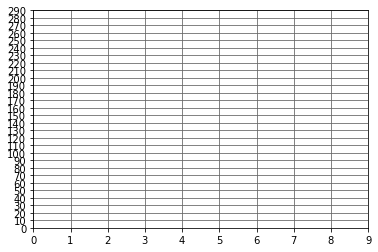

<Figure size 1440x1440 with 0 Axes>

In [21]:
objectId = 0
old_objects = collections.OrderedDict()

# SLAM variables
#initialization

#noise
q = np.array([0.0100, 0.0100])
Q = np.diag(q**2)

m = np.array([.25, 2*math.pi/180])
M = np.diag(m ** 2)

R = np.array([[0],[0],[0]])
u = np.array([[0.5], [0.00001]])

#initialize a landmark array

y = np.zeros([2, 52])

# estimator

robotSize = 3
x = np.zeros([robotSize + np.size(y), 1])
P = np.zeros([np.size(x), np.size(x)])

mapspace = np.arange(1,np.size(x))
l = np.zeros([2, np.size(y)])

r = np.nonzero(mapspace)[0][0:3]
mapspace[r] = 0
x[r] = R

P[r[:, np.newaxis],r] = 0



#back to normal shit

vsLeft = cv2.VideoCapture('videos/left.avi')
vsRight = cv2.VideoCapture('videos/right.avi')




# lft_folder = 'left'
# rt_folder = 'right'

# video_name = 'video.avi'

# left_img = [img for img in os.listdir(lft_folder) if img.endswith(".png")]
# right_img = [img for img in os.listdir(rt_folder) if img.endswith(".png")]

stereo = cv2.StereoBM_create(numDisparities=112, blockSize=15)

plt.ion() ## Note this correction
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xticks(range(0,10))
plt.yticks(range(0,300,10))
fig=plt.figure(figsize=(20,20))



image = 0
cunt = 0
while True:  
    
    
        
    (grabbed, frame) = vsLeft.read()
    (grabbed, frame1) = vsRight.read()
    
    if not grabbed:
        break
    
#     frame = vs.read()

#     lftFrame = cv2.imread(os.path.join(lft_folder, left_img[image]))
#     rtFrame = cv2.imread(os.path.join(rt_folder, right_img[image]))
#     image += 1
    
    
    frame = imutils.resize(frame, width=400)
    frame1 = imutils.resize(frame1, width=400)


    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 0.007843, (300, 300), 127.5)

    net.setInput(blob)
    detections = net.forward()
    
    new_objects = getBoundingBoxes(detections)
   
    objectId, old_objects,new_objects = trackObjects(objectId,old_objects,new_objects)    
      
        
    
    right = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
    left = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    
    disparity = stereo.compute(left, right)
    disparity = cv2.normalize(disparity, None, alpha = 0, beta = 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


    h, w = disparity.shape
    f = 0.1*w                          # guess for focal length
    silly = np.float32([[1, 0,  0, w / 2],
                    [0, -1,  0,  h / 2],  # turn points 180 deg around x-axis,
                    [0, 0, f,  0],  # so that y-axis looks up
                    [0, 0,  0,  1]])
    
    real_points = cv2.reprojectImageTo3D(disparity, silly)

    

#     fig = plt.figure()
#     ax = plt.axes()
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#    # ax.set_zlabel('z')
    
#     ax.scatter( 0,0,marker='s')

    
    for obj in old_objects:
#         xarr = []
#         yarr = []
#         zarr = []
#         if old_objects[obj][0] == 'bottle':
            
#             for y in range(old_objects[obj][3], old_objects[obj][5]):
#                 for x in range(old_objects[obj][4], old_objects[obj][6]):
#                     realxyz = real_points[x,y]
#                     xarr.append(realxyz[0])
#                     yarr.append(realxyz[1])
#                     zarr.append(realxyz[2])


            #work out average and use for plotting

#             ax.scatter(sum(zarr) / len(zarr), old_objects[obj][1])
#             print(sum(zarr) / len(zarr))
#             print(old_objects[obj][1])


        if old_objects[obj][7] == 0:
            # display the prediction
            label = "{},{}".format(old_objects[obj][0], obj)
            cv2.rectangle(frame, (old_objects[obj][3], old_objects[obj][4]), (old_objects[obj][5], old_objects[obj][6]),
                COLORS[obj], 2)
            y = old_objects[obj][4] - 15 if old_objects[obj][4] - 15 > 15 else old_objects[obj][4] + 15
            cv2.putText(frame, label, (old_objects[obj][3], y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[obj], 2)
    
    
    
    
    
    
    
    # robot movement
    ## Prediction
    x[r], R_r, R_n = robotMove(x[r], u) # might need to add noise here at some point dunno
    
    P_rr = P[r[:, np.newaxis],r] # no idea if there is a better way
    P[r,:] = R_r@P[r,:]
    P[:,r] = P[r,:].conj().T
    P[r[:, np.newaxis],r] = R_r @ P_rr @ R_r.conj().T + R_n @ Q @ R_n.conj().T
    
    
    # deal with known landmarks
    if len(np.nonzero(l[0,:])[0]) > 1:
        for lid in old_objects:
            if old_objects[lid][7] == 0:
                
                # The expected measrment
                
                e, E_r, E_l = project(x[r], np.vstack((x[int(l[:, lid-1][0])], x[int(l[:, lid-1][1])])))

                
                
                E_rl = np.hstack((E_r, E_l))
                rl = np.hstack((r, l[:,lid-1].conj().T))
                rl = rl.astype(int)
                E = E_rl @ P[rl[:, np.newaxis],rl] @ E_rl.conj().T
                
                
                
                # The actual measurment
                pnts = real_points[old_objects[lid][1], old_objects[lid][2]]
                yi = np.array([[pnts[0]], [pnts[2]]])
                # need to project first
                yi,tmp1,tmp2 = project(x[r], yi)
                
                # Innovation
                
                z = yi - e
                
#                 if z[1] > math.pi:
#                     z[1] = z[1] - 2*math.pi
#                 if z[1] < -math.pi:
#                     z[1] = z[1] + 2*math.pi
                    
                Z = M + E
        
                
                
                # Kalman Gain
                
                K = P[:, rl] @ E_rl.conj().T @ np.nan_to_num(pow(Z,-1))
                
                # Update
                
                x = x + K @ z
                P = P - K @ Z @ K.conj().T
                
                
                
                
    
    # initialize new landmarks
    if len(new_objects) > 0:
        tmp = np.nonzero(l[1,:] == 0)[0] 

        if len(tmp) > 0:
            lid = tmp[0]
            emptyMapSpaces = np.nonzero(mapspace)
            if len(emptyMapSpaces[0]) > 1:
                s = np.array([emptyMapSpaces[0][0], emptyMapSpaces[0][1]])
                if len(s) > 1:
                    mapspace[s] = 0
                    l[:,lid] = s.conj().T


                # Measurment
                
                    
                    pnts = real_points[new_objects[0][1], new_objects[0][2]]
                    yi = np.array([[pnts[0]], [pnts[2]]])
                    #nned to project first

                    yi,tmp1,tmp2 = project(x[r], yi)


                    idx = l[:,lid]
                    x[int(idx[0])], x[int(idx[1])], L_r, L_y = backProject(x[r], yi)

                    P[s,:] = L_r @ P[r,:]
                    P[:,s] = np.array(P[s,:]).conj().T
                    P[s[:, np.newaxis],s] = L_r @ P[r[:, np.newaxis],r] @ L_r.conj().T + L_y @ M @ L_y.conj().T

                    del new_objects[0]

            
 
    
#     plt.cla()
    
#     idx = np.nonzero(l[0,:])
#     lx = l[0,idx]
#     ly = l[1,idx]
    
#     if len(lx[0]) > 0:
#         plt.scatter(x[0], x[1], marker='s')
#         plt.scatter(x[np.array(lx[0]).astype(int)], x[np.array(ly[0]).astype(int)])
#         display.clear_output(wait=True)
#         display.display(plt.gcf())


    
    
    #update robot position
    
    
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
    # update the FPS counter
#     fps.update()
    
    
    new_centroid = [] 
    time.sleep(5)
    
# stop the timer and display FPS information
vsLeft.releaseq()
vsRight.release()
    # fps.stop()
#print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
# do a bit of cleanup
cv2.destroyAllWindows()


In [ ]:
i

In [ ]:
[x[np.array(lx[0]).astype(int)], x[np.array(ly[0]).astype(int)]]

In [ ]:
old_objects

In [ ]:
new_objects

In [ ]:

from IPython import display
plt.ion() ## Note this correction
fig=plt.figure(figsize=(20,20))

plt.axis([0,1000,0,1])

i=0
x=list()
y=list()

while i <1000:
    temp_y=np.random.random()
    x.append(i)
    y.append(temp_y)
    plt.scatter(i,temp_y)
    i+=1
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)


In [ ]:
with open('C:/Users/rparg/Downloads/data_odometry_poses/dataset/poses/00.txt') as f:
			truth =f .readlines()

In [ ]:
traj = np.zeros((600,600,3), dtype=np.uint8)
for img_id in range(4541):
    img = cv2.imread('/Users/rparg/Downloads/00/image_0/'+str(img_id).zfill(6)+'.png', 0)

    
    ss = truth[img_id].strip().split()
    true_x = float(ss[3])
    true_y = float(ss[7])
    true_z = float(ss[11])
    true_x, true_y = int(true_x)+290, int(true_z)+90

    #cv2.circle(traj, (draw_x,draw_y), 1, (img_id*255/4540,255-img_id*255/4540,0), 1)
    cv2.circle(traj, (true_x,true_y), 1, (0,0,255), 2)
    cv2.rectangle(traj, (10, 20), (600, 60), (0,0,0), -1)
    #     text = "Coordinates: x=%2fm y=%2fm z=%2fm"%(x,y,z)
    #     cv2.putText(traj, text, (20,40), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1, 8)

    cv2.imshow('Road facing camera', img)
    cv2.imshow('Trajectory', traj)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
    

#cv2.imwrite('map.png', traj)
cv2.destroyAllWindows()

In [ ]:
truth